O que eu espero que vocês entreguem é um Jupyter Notebook com o trabalho até o modelo chegar ao ponto de ter os datasets de treino e teste analisados e preparados para as inferências.

O modelo é bem conhecido, é o dataset dos passageiros do Titanic e a variável alvo é se ele sobreviveu ou não.

Este desafio está também no Kaggle. O link é: https://www.kaggle.com/c/titanic

Existem alguns milhões de páginas falando sobre este assunto na internet.

Então, vocês tem muito material de referência.

Pensando no CRISP-DS, quero ver a análise do problema de negócios, a compreensão sobre os dados (extração dos dados, limpeza) e a preparação (análise exploratória).

Bom trabalho!

A propósito, como vocês terão bastante tempo para terminar o trabalho e existe muito material pronto, vou avaliar com cuidado além da entrega, a qualidade da entrega.


In [77]:
!gdown --id 1BTKBoCx_9JqCU2TB15hAMbtU11Llc1HP
!pip install kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic

Downloading...
From: https://drive.google.com/uc?id=1BTKBoCx_9JqCU2TB15hAMbtU11Llc1HP
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 60.2kB/s]
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm

import xlrd
import itertools
import pylab
import warnings

from datetime import datetime as dt
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile, chi2
%matplotlib inline

pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')


In [147]:
def extract_title(df):
  df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip().lower())

def age_outlier(df):
  df['Age'] = np.where(df['Age']>68, 68, df['Age'])

def fare_outlier(df):
  df['Fare'] = np.where(df['Fare']>99, np.random.randint(45, 60, 1)[0], df['Fare'])

  print(df.groupby('Pclass')['Fare'].mean())

  df['Fare'] = np.where(((df['Fare'] == 0) & (df['Pclass']==1)), 49, df['Fare'])
  df['Fare'] = np.where(((df['Fare'] == 0) & (df['Pclass']==2)), 20, df['Fare'])
  df['Fare'] = np.where(((df['Fare'] == 0) & (df['Pclass']==3)), 14, df['Fare'])

def pclass_fare(df):
  df['Pclass'] = np.whare((df['Pclass'].isnull()) & (df['Fare'] < 14.99), 3.0, df['Pclass'])
  df['Pclass'] = np.whare((df['Pclass'].isnull()) & (df['Fare'] >= 14.99) & (df['Fare'] < 14.99), 2.0, df['Pclass'])
  df['Pclass'] = np.whare((df['Pclass'].isnull()) & (df['Fare'] >= 14.99), 1.0, df['Pclass'])

def sex_null_format(df, lista_male):
  df['Sex'] = np.where((df['Sex'].isnull()) & (df['Title'].isin(lista_male)), 'male', df['Sex'])
  df['Sex'].fillna('female', inplace=True)
  df['Sex'] = np.where((df['Sex'].str.lower().str.strip().str.startswith('ma'), 'male', 'female'))

def impute_age(age_pclass_titulo):
  age = age_pclass_titulo[0]
  pclass = age_pclass_titulo[1]
  titulo = age_pclass_titulo[2]
  if pd.isnull(age):
    if pclass == 1:

      if titulo == 'miss':
        return 30

      elif titulo == 'mrs':
        return 41

      elif titulo == 'master':
        return 6

      elif titulo == 'mr':
        return 41

      elif titulo == 'dr':
        return 44

    elif pclass == 2:

      if titulo == 'miss':
        return 22

      elif titulo == 'mrs':
        return 34

      elif titulo == 'master':
        return 3

      elif titulo == 'mr':
        return 33

      elif pclass == 3:
        if titulo == 'miss':
          return 17

        elif titulo == 'mrs':
          return 34

        elif titulo == 'master':
          return 6

      else:
        return 29

def cabin_split_null(df, cabin_class_a, cabin_class_b, cabin_class_c):
  df['Cabin'] = df['Cabin'].str[0].str.lower().str.strip()
  
  df['Cabin'] = np.where((df['Cabin'].isnull()) & (df['Pclass']==1), np.random.choice(cabin_class_a, size = 1)[0], df['Cabin'])

  df['Cabin'] = np.where((df['Cabin'].isnull()) & (df['Pclass']==3), np.random.choice(cabin_class_c, size = 1)[0], df['Cabin'])

  df['Cabin'] = np.where(df['Cabin'].isnull(), np.random.choice(cabin_class_b, size = 1)[0], df['Cabin'])

  df['Cabin'] = np.where((df['Pclass'] == 1) & (df['Cabin'] == 't'), 'a', df['Cabin'])

In [80]:
df = pd.read_csv('train.csv')
df.set_index('PassengerId', inplace=True)

In [81]:
colunms = [col for col in df.columns]
col_null_value = []
for c in colunms:
  if df[c].isnull().values.any():
    col_null_value.append(c)
  print(f"Coluna {c}: {df[c].isnull().values.any()}")
col_null_value

Coluna Survived: False
Coluna Pclass: False
Coluna Name: False
Coluna Sex: False
Coluna Age: True
Coluna SibSp: False
Coluna Parch: False
Coluna Ticket: False
Coluna Fare: False
Coluna Cabin: True
Coluna Embarked: True


['Age', 'Cabin', 'Embarked']

In [121]:
df.describe().transpose()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,22.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,38.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,miss,26.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,35.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,rev,27.0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,miss,19.0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,miss,NaN


In [83]:
#Variaveis categoricas
cat_col = [var for var in colunms if df[var].dtype == 'O']
df.loc[:, cat_col].head()
num_col = [var for var in colunms if df[var].dtype != 'O']
df.loc[:, num_col].head()

,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,0,3,22.0,1,0,7.2500
2,1,1,38.0,1,0,71.2833
3,1,3,26.0,0,0,7.9250
4,1,1,35.0,1,0,53.1000
5,0,3,35.0,0,0,8.0500


In [84]:
print(f'Total de passageiros no dataset: {df.shape[0]}')
print(f'Total de passageiros sem dados faltantes: {df.dropna().shape[0]}')
print(f"Percentual de dados com 100% do preenchimento dos dados: {round((df.dropna().shape[0] / len(df)*100), 2)}")

Total de passageiros no dataset: 891
Total de passageiros sem dados faltantes: 183
Percentual de dados com 100% do preenchimento dos dados: 20.54


In [85]:
# for c in col_null_value:
#   print('########################################################################################################################################################################################################')
#   print(c)
#   print(df[df[c].isnull()].shape[0])
#   print(df[df[c].isnull()])
#   print('########################################################################################################################################################################################################')

In [86]:
df.isnull().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [87]:
extract_title(df)

In [88]:
col_null_value

['Age', 'Cabin', 'Embarked']

In [89]:
# array(['mr', 'mrs', 'miss', 'master', 'don', 'rev', 'dr', 'mme', 'ms',
#        'major', 'lady', 'sir', 'mlle', 'col', 'capt', 'the countess',
#        'jonkheer'], dtype=object)

df['Title'].unique()

array(['mr', 'mrs', 'miss', 'master', 'don', 'rev', 'dr', 'mme', 'ms',
       'major', 'lady', 'sir', 'mlle', 'col', 'capt', 'the countess',
       'jonkheer'], dtype=object)

Text(0.5, 0, 'Quant. por titulos')

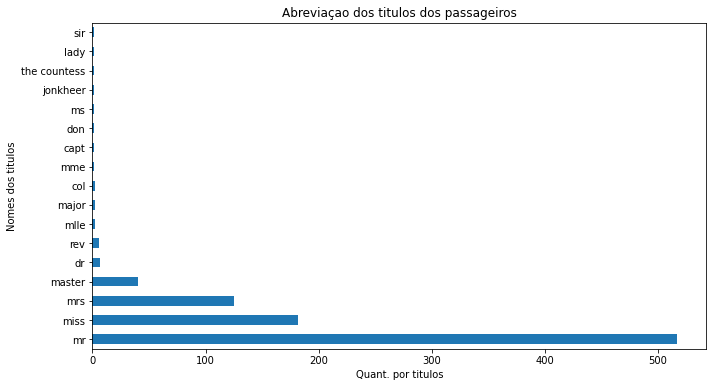

In [90]:
# col_num = ['Age', 'Cabin', 'Embarked']

fig = plt.figure(figsize=(11, 6))
fig = df['Title'].value_counts().plot.barh()
fig.set_title('Abreviaçao dos titulos dos passageiros')
fig.set_ylabel('Nomes dos titulos')
fig.set_xlabel('Quant. por titulos')

Text(0, 0.5, 'Val. Preço')

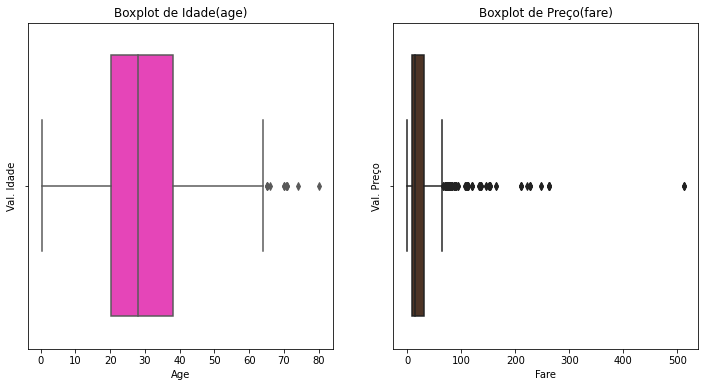

In [91]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
fig = sns.boxplot(x='Age', data=df, orient="v", color='#ff2bc4')
fig.set_title('Boxplot de Idade(age)')
fig.set_ylabel('Val. Idade')

plt.subplot(1,2,2)
fig = sns.boxplot(x='Fare', data=df, orient="v", color='#54321f')
fig.set_title('Boxplot de Preço(fare)')
fig.set_ylabel('Val. Preço')

Text(0, 0.5, 'Quant. de obs. com idade no eixo X')

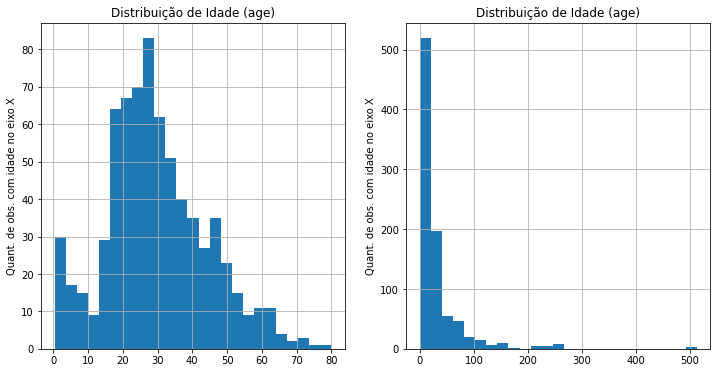

In [92]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
fig = df['Age'].hist(bins=25)
fig.set_title('Distribuição de Idade (age)')
fig.set_ylabel('Quant. de obs. com idade no eixo X')

plt.subplot(1,2,2)
fig = df['Fare'].hist(bins=25)
fig.set_title('Distribuição de Idade (age)')
fig.set_ylabel('Quant. de obs. com idade no eixo X')

In [ ]:
quartil_inferior = df['Age'].mean() - 2.7 * df['Age'].std()

quartil_superior = df['Age'].mean() + 2.7 * df['Age'].std()

print(f'Valores outliers min: {quartil_inferior} e max: {quartil_superior}')
quant_outliers = df[df['Age']>68].count()[0]
print(f'Quant de registros alterados para o limite superior: {quant_outliers}')
age_outlier(df)

In [103]:
IQR = df['Fare'].describe()[6] - df['Fare'].describe()[4]
quartil_sup_fare = df['Fare'].quantile(0.75) + (IQR * 3)
quartil_inf_fare = df['Fare'].quantile(0.25) - (IQR * 3)
alter_reg = df[df['Fare']>99].count()[0]
print(f'Val. outlier ref a feature que estão entre {quartil_sup_fare} e {quartil_inf_fare}')
print(f'Quant. de registros que serão alterados para o quartil sup {alter_reg}')

Val. outlier ref a feature que estão entre 100.2688 e -61.358399999999996
Quant. de registros que serão alterados para o quartil sup 53


In [109]:
df[df['Fare']>99]['Pclass'].value_counts()

1    53
Name: Pclass, dtype: int64

In [116]:
df[(df['Pclass'] == 1) & (df['Fare']<99)]['Fare'].mean()
df[df['Pclass']==1]['Fare'].mean()

84.15468749999992

In [118]:
fare_outlier(df)

Pclass
1    51.757736
2    20.662183
3    13.675550
Name: Fare, dtype: float64


Text(0, 0.5, 'Val. Preço')

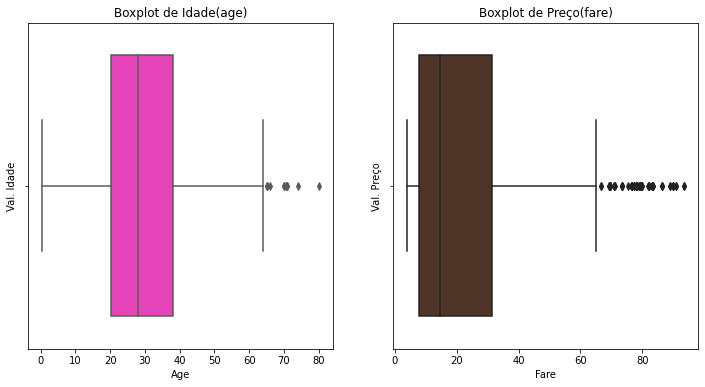

In [119]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
fig = sns.boxplot(x='Age', data=df, orient="v", color='#ff2bc4')
fig.set_title('Boxplot de Idade(age)')
fig.set_ylabel('Val. Idade')

plt.subplot(1,2,2)
fig = sns.boxplot(x='Fare', data=df, orient="v", color='#54321f')
fig.set_title('Boxplot de Preço(fare)')
fig.set_ylabel('Val. Preço')

In [ ]:
male_title = ['mr', 'master', 'don', 'rev', 'dr', 'major', 'sir', 'col', 'capt', 'jonkheer']
sex_null_format(df, male_title)

In [122]:
df.groupby(['Pclass', 'Sex'])['Age'].mean()

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [135]:
df.groupby(['Pclass', 'Title'])['Age'].mean()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,22.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,38.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,miss,26.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,35.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,rev,27.0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,miss,19.0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,miss,NaN


In [136]:
df['Age'] = df[['Age', 'Pclass', 'Title']].apply(impute_age, axis = 1)

In [137]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [142]:
df['ale_cabin'] = df['Cabin'].str[0].str.lower().str.strip()

In [143]:
df.groupby('Pclass')['ale_cabin'].value_counts()

Pclass  ale_cabin
1       c            59
        b            47
        d            29
        e            25
        a            15
        t             1
2       f             8
        d             4
        e             4
3       f             5
        g             4
        e             3
Name: ale_cabin, dtype: int64

In [149]:
cabin_class_a = ['c','b','d','e','a','t']
cabin_class_b = ['f', 'd', 'e']
cabin_class_c = ['e', 'g', 'f']

cabin_split_null(df, cabin_class_a, cabin_class_b, cabin_class_c)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age,ale_cabin
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,NaN,1,0,A/5 21171,7.2500,g,S,mr,22.0,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,NaN,1,0,PC 17599,71.2833,c,C,mrs,38.0,c
3,1,3,"Heikkinen, Miss. Laina",female,NaN,0,0,STON/O2. 3101282,7.9250,g,S,miss,26.0,NaN
